## Load Packages

In [11]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import numpy as np
import seaborn as sns
import math
import bayesflow as bf
import os
from numba import njit
from sklearn.preprocessing import StandardScaler
import numba as nb
import copy
import random
from tensorflow.keras import backend as K
import gc
from pathlib import Path
import ipynbname
from diffusion_functions import diffusion_trial, diffusion_prior, generate_condition_matrix, diffusion_configurator
# Suppress scientific notation for floats
np.set_printoptions(suppress=True)



## Get file path

In [12]:
notebook_path = Path(ipynbname.path()).resolve().parent
root_dir = notebook_path.parent
#print(root_dir)

## Checkpoint

In [13]:
checkpoint_path_standard = root_dir/"network/standard"
checkpoint_path_robust = root_dir/"network/robust"


## Define DDM

In [14]:
@nb.njit
def set_seed(value):
    np.random.seed(value)

@nb.jit(nopython=True, cache=True)
def diffusion_trial(v, a, z, ndt, dt=1e-3, max_steps=15000):
    """Simulates a trial from the diffusion model."""
    n_steps = 0
    x = a * z
    mu = v * dt
    sigma = math.sqrt(dt)

    # Simulate a single DM path
    for n_steps in range(max_steps):
        # DDM equation
        x += mu + sigma * np.random.normal(0,1)
        # Stop when out of bounds
        if x <= 0.0 or x >= a:
            break
    
    rt = float(n_steps) * dt
    
    if x > 0:
        resp = 1.
    else:
        resp = 0.
    return rt+ndt,resp


## Define priors

In [15]:
RNG = np.random.default_rng(2023)
def diffusion_prior():
    "Generates a random draw from the joint prior distribution."
    #normal distribution for the drift rates
    drifts_1 = RNG.uniform(-7,7)
    drifts_2 = RNG.uniform(-7,7)
    drifts_3 = RNG.uniform(-7,7)
    drifts_4 = RNG.uniform(-7,7)
    drifts_5 = RNG.uniform(-7,7)
    threshold = RNG.uniform(0.5,5)
    ndt = RNG.gamma(1.5, 1 / 5.0)
    z = RNG.uniform(.01,.99)
    return np.hstack((drifts_1, drifts_2, drifts_3, drifts_4, drifts_5, threshold, z, ndt))

PARAM_NAMES = [
    "Drift rate 1",
    "Drift rate 2",
    "Drift rate 3",
    "Drift rate 4",
    "Drift rate 5",
    "Boundary separation",
    "Response bias",
    "Non-decision time"
]

prior = bf.simulation.Prior(prior_fun=diffusion_prior, param_names=PARAM_NAMES)

## Define the study design information

In [16]:
MIN_OBS = 100
MAX_OBS = 5000
NUM_CONDITIONS=5

def random_num_obs(min_obs=MIN_OBS, max_obs=MAX_OBS):
#   """Draws a random number of observations for all simulations in a batch."""

   return RNG.integers(low=min_obs, high=max_obs + 1)

def generate_condition_matrix(num_obs, num_conditions=NUM_CONDITIONS):
    """Generates a random design matrix with approximate counts of conditions."""
    # Calculate approximate counts with some randomness
    counts = np.random.multinomial(num_obs, [1/num_conditions] * num_conditions)
    
    # Create the condition array
    condition = np.concatenate([np.full(count, i) for i, count in enumerate(counts)])
    
    # Shuffle the condition array to randomize order
    np.random.shuffle(condition)
    
    return condition

context_gen = bf.simulation.ContextGenerator(
    non_batchable_context_fun=random_num_obs,
    batchable_context_fun=generate_condition_matrix,
    use_non_batchable_for_batchable=True
)

## Combine the design information and the trial-wise simulator

In [17]:
@nb.jit(nopython=True)

def diffusion_experiment_real_data_problem_standard(theta, design_matrix, num_obs, rng=None, *args):
    out = np.zeros((num_obs, 2))
    for n in range(num_obs):
        index = design_matrix[n]
        rt,resp = diffusion_trial(theta[index], theta[-3], theta[-2], theta[-1])
        out[n, :] = np.array([rt,resp])
    
    #log transformation
    out[:,0] = np.log(out[:,0])

    
    return out

simulator_real_data_problem_standard = bf.simulation.Simulator(simulator_fun=diffusion_experiment_real_data_problem_standard, context_generator=context_gen)

model_real_data_problem_standard = bf.simulation.GenerativeModel(prior=prior, simulator=simulator_real_data_problem_standard, name="DDM")

@nb.jit(nopython=True)

def diffusion_experiment_real_data_problem_robust(theta, design_matrix, num_obs, rng=None, *args):
    out = np.zeros((num_obs, 2))
    for n in range(num_obs):
        index = design_matrix[n]
        rt,resp = diffusion_trial(theta[index], theta[-3], theta[-2], theta[-1])
        out[n, :] = np.array([rt,resp])
    
    #log transformation
    out[:,0] = np.log(out[:,0])
    
    CC=np.random.standard_t(df=1,size=num_obs)
    X=np.random.binomial(n=1,p=.1,size=num_obs)
    out[:,0] = (1-X)*out[:,0] + (X)*np.log(np.abs(CC))
    out[:,1] = (1-X)*out[:,1] + (X)*np.random.binomial(n=1,p=0.5,size=num_obs)
    
    return out

simulator_real_data_problem_robust = bf.simulation.Simulator(simulator_fun=diffusion_experiment_real_data_problem_robust, context_generator=context_gen)

model_real_data_problem_robust = bf.simulation.GenerativeModel(prior=prior, simulator=simulator_real_data_problem_robust, name="DDM")

INFO:root:Performing 2 pilot runs with the DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 2460, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable context: ()
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!
INFO:root:Performing 2 pilot runs with the DDM model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 8)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 1693, 2)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:Shape of simulation non-batchable contex

## Configurator

In [34]:
from tensorflow.keras.utils import to_categorical

#a configurator extracts the results of the generative model to a format
#that the neural network would like
#transformation of the data/ parameters
#Try this with a example simulation
def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    data = forward_dict["sim_data"]

    # Convert list of condition indicators to a 2D array and add a
    # trailing dimension of 1, so shape becomes (batch_size, num_obs, 1)
    # We need this in order to easily concatenate the context with the data
    context = np.array(forward_dict["sim_batchable_context"])[..., None]

    # One-hot encoding of integer choices
    categorical_resp = to_categorical(data[:, :, 1], num_classes=2)

    # Concatenate rt, resp, context
    out_dict["summary_conditions"] = np.c_[data[:, :, :1], categorical_resp, context].astype(np.float32)

    # Make inference network aware of varying numbers of trials
    # We create a vector of shape (batch_size, 1) by repeating the sqrt(num_obs)
    vec_num_obs = forward_dict["sim_non_batchable_context"] * np.ones((data.shape[0], 1))
    out_dict["direct_conditions"] = np.sqrt(vec_num_obs).astype(np.float32)

    # Get data generating parameters
    out_dict["parameters"] = forward_dict["prior_draws"].astype(np.float32)


    return out_dict



## Network

In [35]:
#SetTransformer() is a permutation invariant network
#input_dim = how many dimensions the configured data would have
#here we have a RT, dummy coded variable for the two choices (one or two?), the context dummy
summary_net_real_data_problem_standard = bf.networks.SetTransformer(input_dim=4, summary_dim=15, name="ddm_summary")

#we are turning off the kernel and dropout regularization for the networks 
#since we don’t need these for online training
inference_net_real_data_problem_standard = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_design="interleaved",
    name="ddm_inference",
)

amortizer_real_data_problem_standard = bf.amortizers.AmortizedPosterior(inference_net_real_data_problem_standard, summary_net_real_data_problem_standard, name="ddm_amortizer_c")


trainer_real_data_problem_standard = bf.trainers.Trainer(
    generative_model=model_real_data_problem_standard, amortizer=amortizer_real_data_problem_standard, configurator=configurator,
    checkpoint_path = checkpoint_path_standard
)
amortizer_real_data_problem_standard.summary()

#SetTransformer() is a permutation invariant network
#input_dim = how many dimensions the configured data would have
#here we have a RT, dummy coded variable for the two choices (one or two?), the context dummy
summary_net_real_data_problem_robust = bf.networks.SetTransformer(input_dim=4, summary_dim=15, name="ddm_summary")

#we are turning off the kernel and dropout regularization for the networks 
#since we don’t need these for online training
inference_net_real_data_problem_robust = bf.networks.InvertibleNetwork(
    num_params=len(prior.param_names),
    coupling_design="interleaved",
    name="ddm_inference",
)

amortizer_real_data_problem_robust = bf.amortizers.AmortizedPosterior(inference_net_real_data_problem_robust, summary_net_real_data_problem_robust, name="ddm_amortizer_c")


trainer_real_data_problem_robust = bf.trainers.Trainer(
    generative_model=model_real_data_problem_robust, amortizer=amortizer_real_data_problem_robust, configurator=configurator,
    checkpoint_path = checkpoint_path_robust
)
amortizer_real_data_problem_robust.summary()


INFO:root:Loaded loss history from C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\4 real data problem\network\standard\history_250.pkl.
INFO:root:Networks loaded from C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\4 real data problem\network\standard\ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "ddm_amortizer_c"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ddm_inference (InvertibleN  multiple                  503688    
 etwork)                                                         
                                                                 
 ddm_summary (SetTransforme  multiple                  48668     
 r)                                                              
                                                                 
Total params: 552356 (2.11 MB)
Trainable params: 552260 (2.11 MB)
Non-trainable params: 96 (384.00 Byte)
_________________________________________________________________


INFO:root:Loaded loss history from C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\4 real data problem\network\robust\history_250.pkl.
INFO:root:Networks loaded from C:\Users\u0145642\OneDrive - KU Leuven\Desktop\Robust amortized Bayesian inference\4 real data problem\network\robust\ckpt-250
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Model: "ddm_amortizer_c"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ddm_inference (InvertibleN  multiple                  503688    
 etwork)                                                         
                                                                 
 ddm_summary (SetTransforme  multiple                  48668     
 r)                                                              
                                                                 
Total params: 552356 (2.11 MB)
Trainable params: 552260 (2.11 MB)
Non-trainable params: 96 (384.00 Byte)
_________________________________________________________________


## Parameter recovery

Estimation will be performed on data sets with 3754 simulated trials.


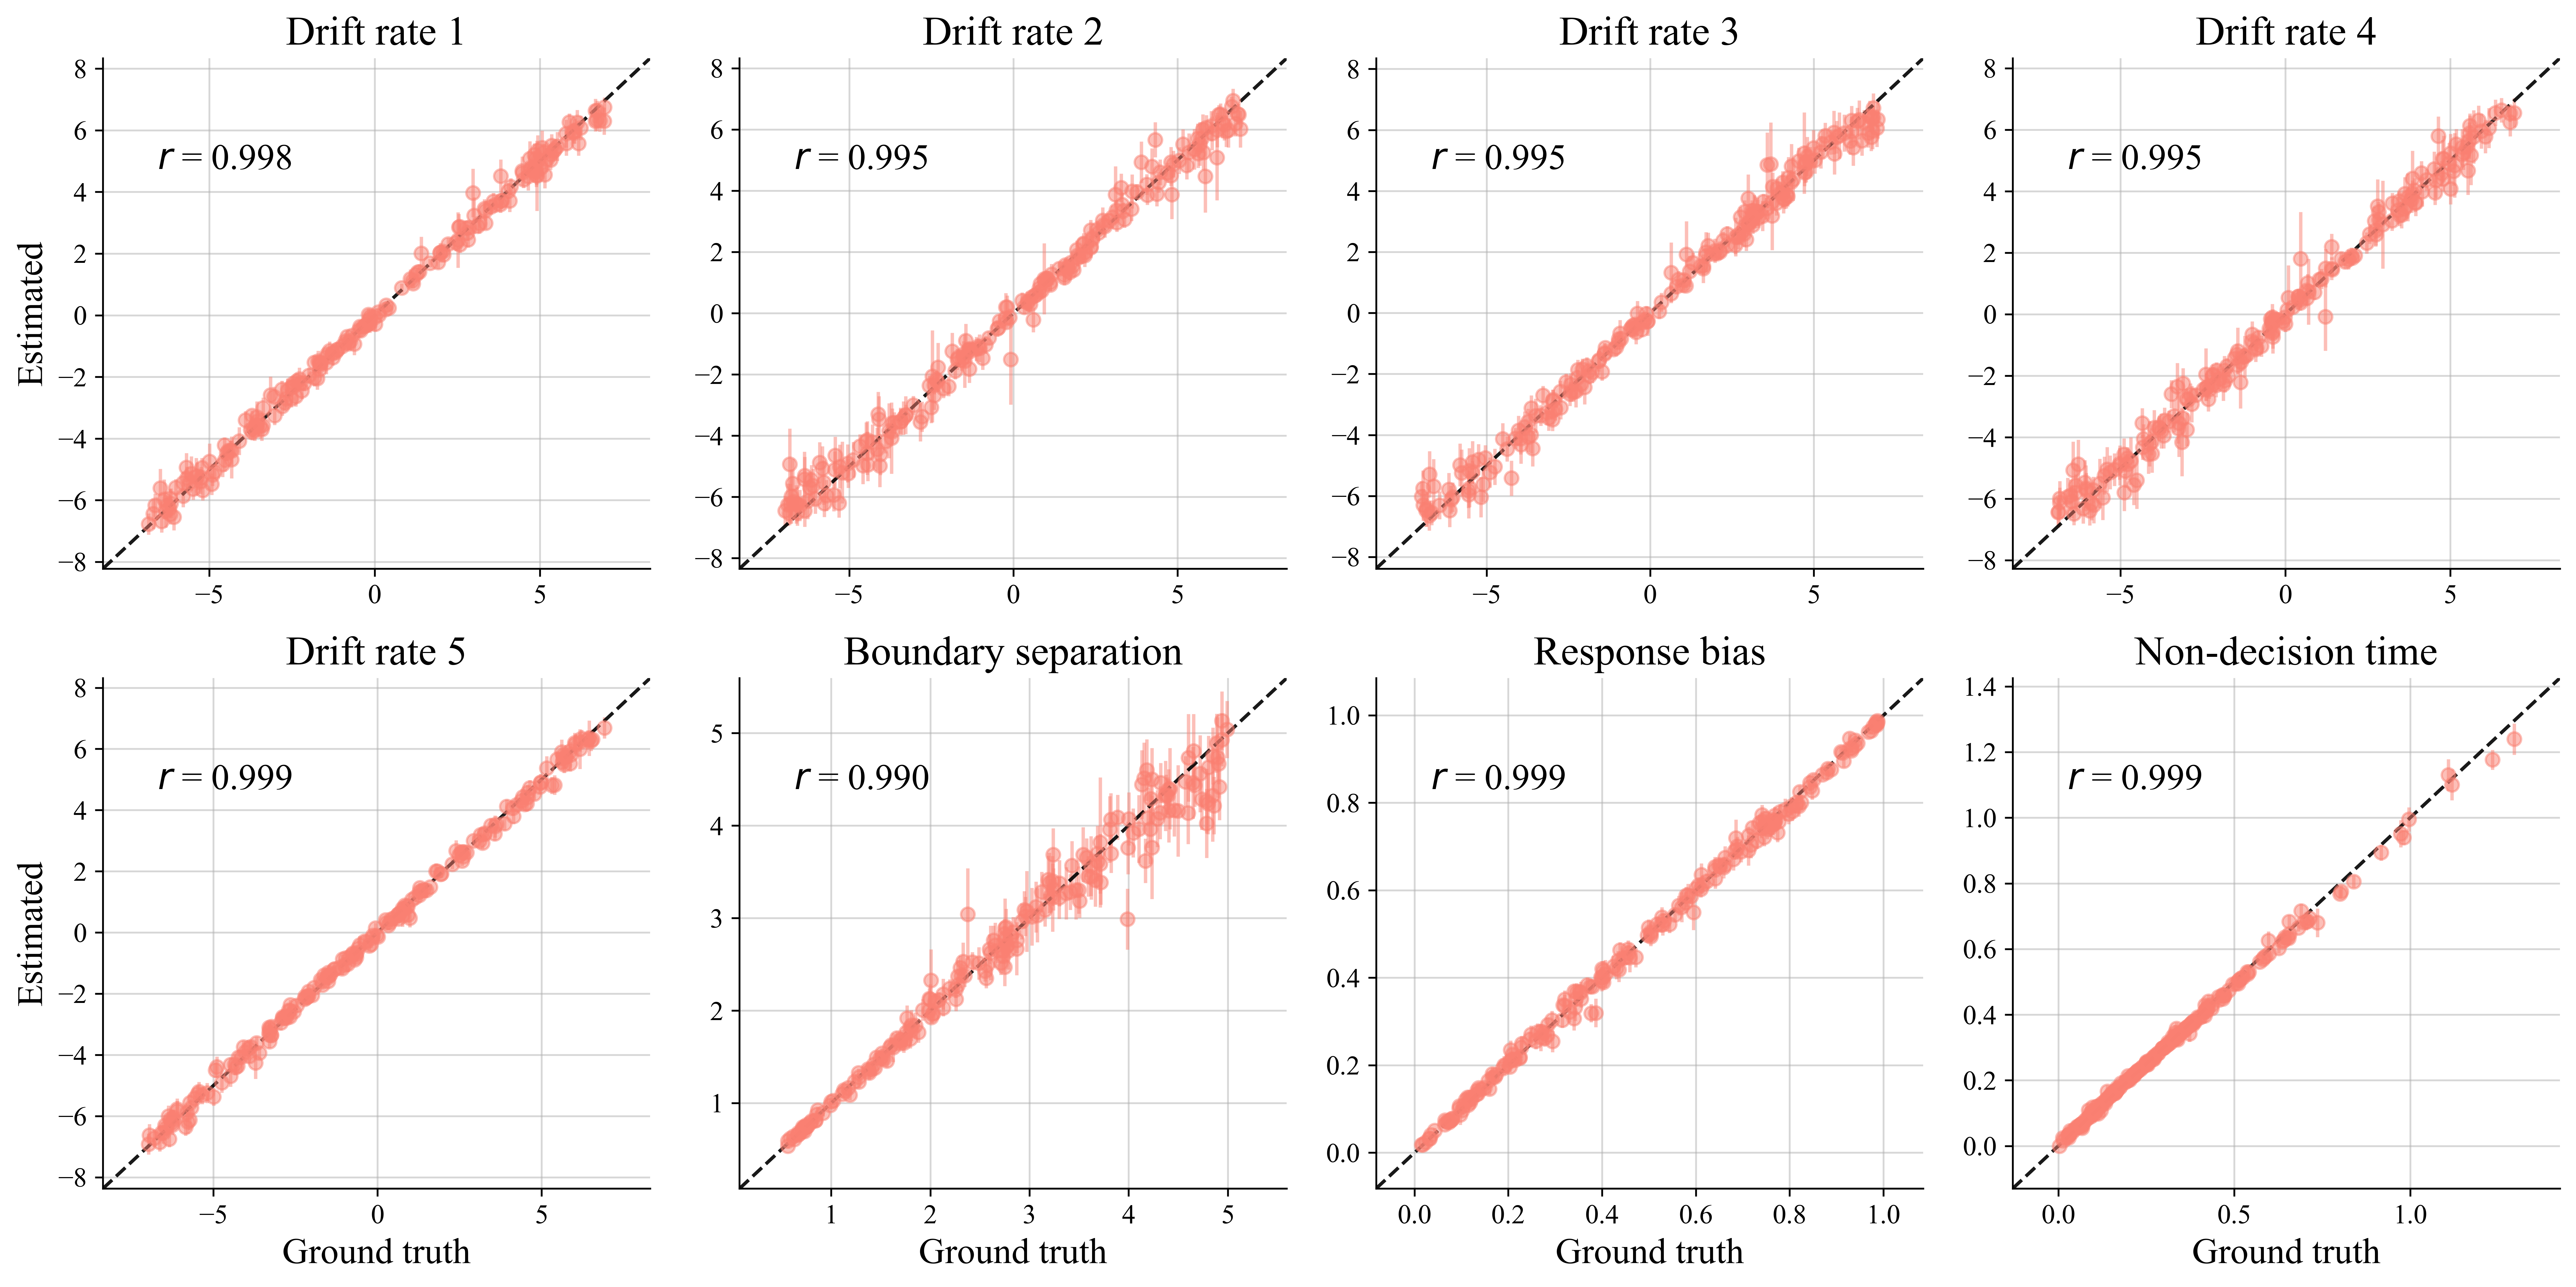

In [37]:
# Generate some validation data
validation_sims = configurator(model_real_data_problem_standard(batch_size=200))

# Extract unstandardized prior draws and transform to original scale
prior_samples = validation_sims["parameters"] 

print(
    f"Estimation will be performed on data sets with {validation_sims['summary_conditions'].shape[1]} simulated trials."
)

# Generate 100 posterior draws for each of the 1000 simulated data sets
post_samples = amortizer_real_data_problem_standard.sample(validation_sims, n_samples=1000)
post_samples.shape

plt.rcParams['font.family'] = 'Times New Roman'
f = bf.diagnostics.plot_recovery(
    post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean, uncertainty_agg=np.std,color='salmon',add_r2=False)
f.set_dpi(600)

Estimation will be performed on data sets with 2491 simulated trials.


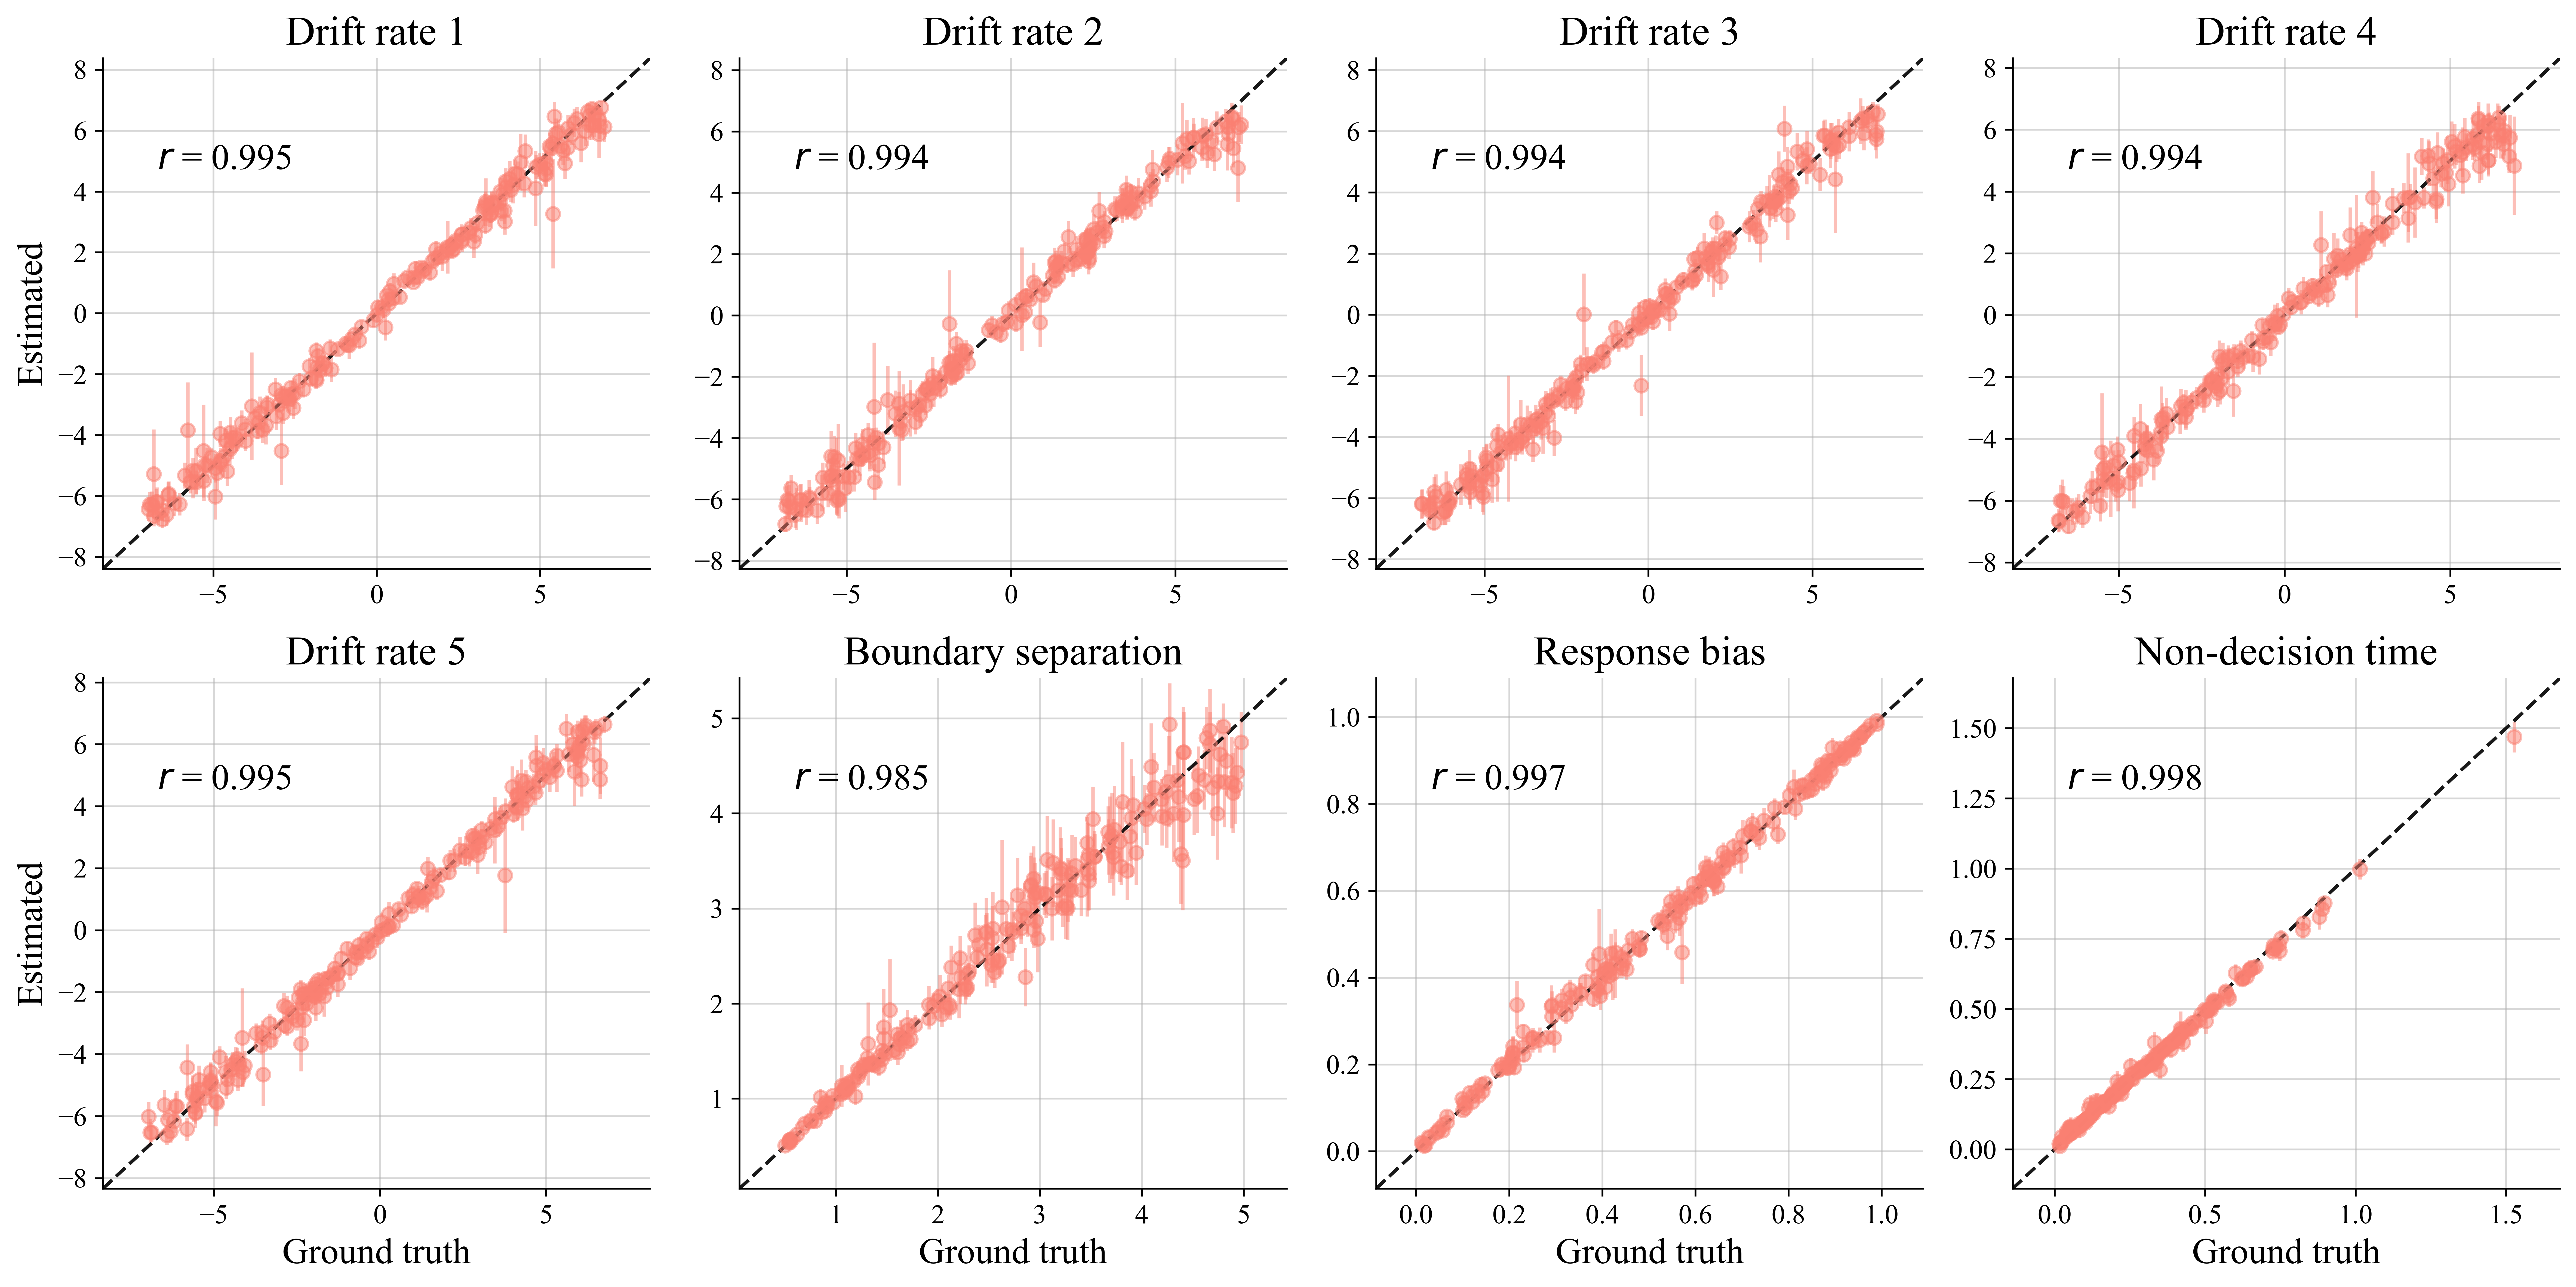

In [15]:
# Generate some validation data
validation_sims = configurator(model_real_data_problem_robust(batch_size=200))

# Extract unstandardized prior draws and transform to original scale
prior_samples = validation_sims["parameters"] 

print(
    f"Estimation will be performed on data sets with {validation_sims['summary_conditions'].shape[1]} simulated trials."
)

# Generate 100 posterior draws for each of the 1000 simulated data sets
post_samples = amortizer_real_data_problem_robust.sample(validation_sims, n_samples=1000)
post_samples.shape

plt.rcParams['font.family'] = 'Times New Roman'
f = bf.diagnostics.plot_recovery(
    post_samples, prior_samples, param_names=prior.param_names, point_agg=np.mean, uncertainty_agg=np.std,color='salmon',add_r2=False)
f.set_dpi(600)

## Fitting data

In [38]:
# import data
import pandas as pd

rr98 = pd.read_csv(root_dir/"R related files/rr98.txt", delimiter=' ') 
#delete data smaller than 200 ms and larger than 2.5s
rr98_cleaned = rr98[(rr98['rt'] >= 0.20) & (rr98['rt'] <= 2.5)] 
#store the outliers
rr98_outlier_speed = rr98[((rr98['rt'] < 0.20) | (rr98['rt'] > 2.5)) & (rr98['instruction'] == 'speed')]
rr98_outlier_accuracy = rr98[((rr98['rt'] < 0.20) | (rr98['rt'] > 2.5)) & (rr98['instruction'] == 'accuracy')]

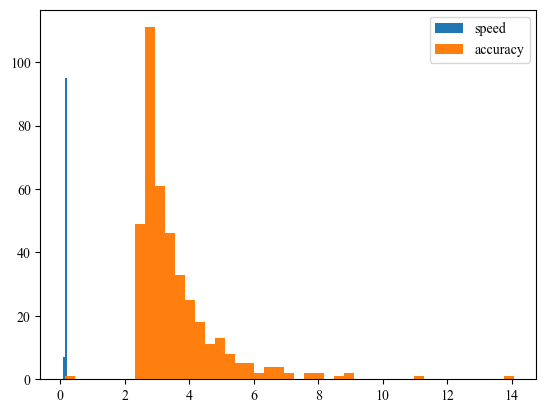

In [39]:
plt.hist(rr98_outlier_speed['rt'], bins = 45, label = 'speed')
plt.hist(rr98_outlier_accuracy['rt'], bins = 45, label = 'accuracy')
plt.legend()
plt.show()

In [40]:
mean_response = rr98.groupby(['strength_bin','id','instruction'])['y'].mean().reset_index()
pivot_response = mean_response.pivot(index='strength_bin', columns=['id','instruction'], values='y')

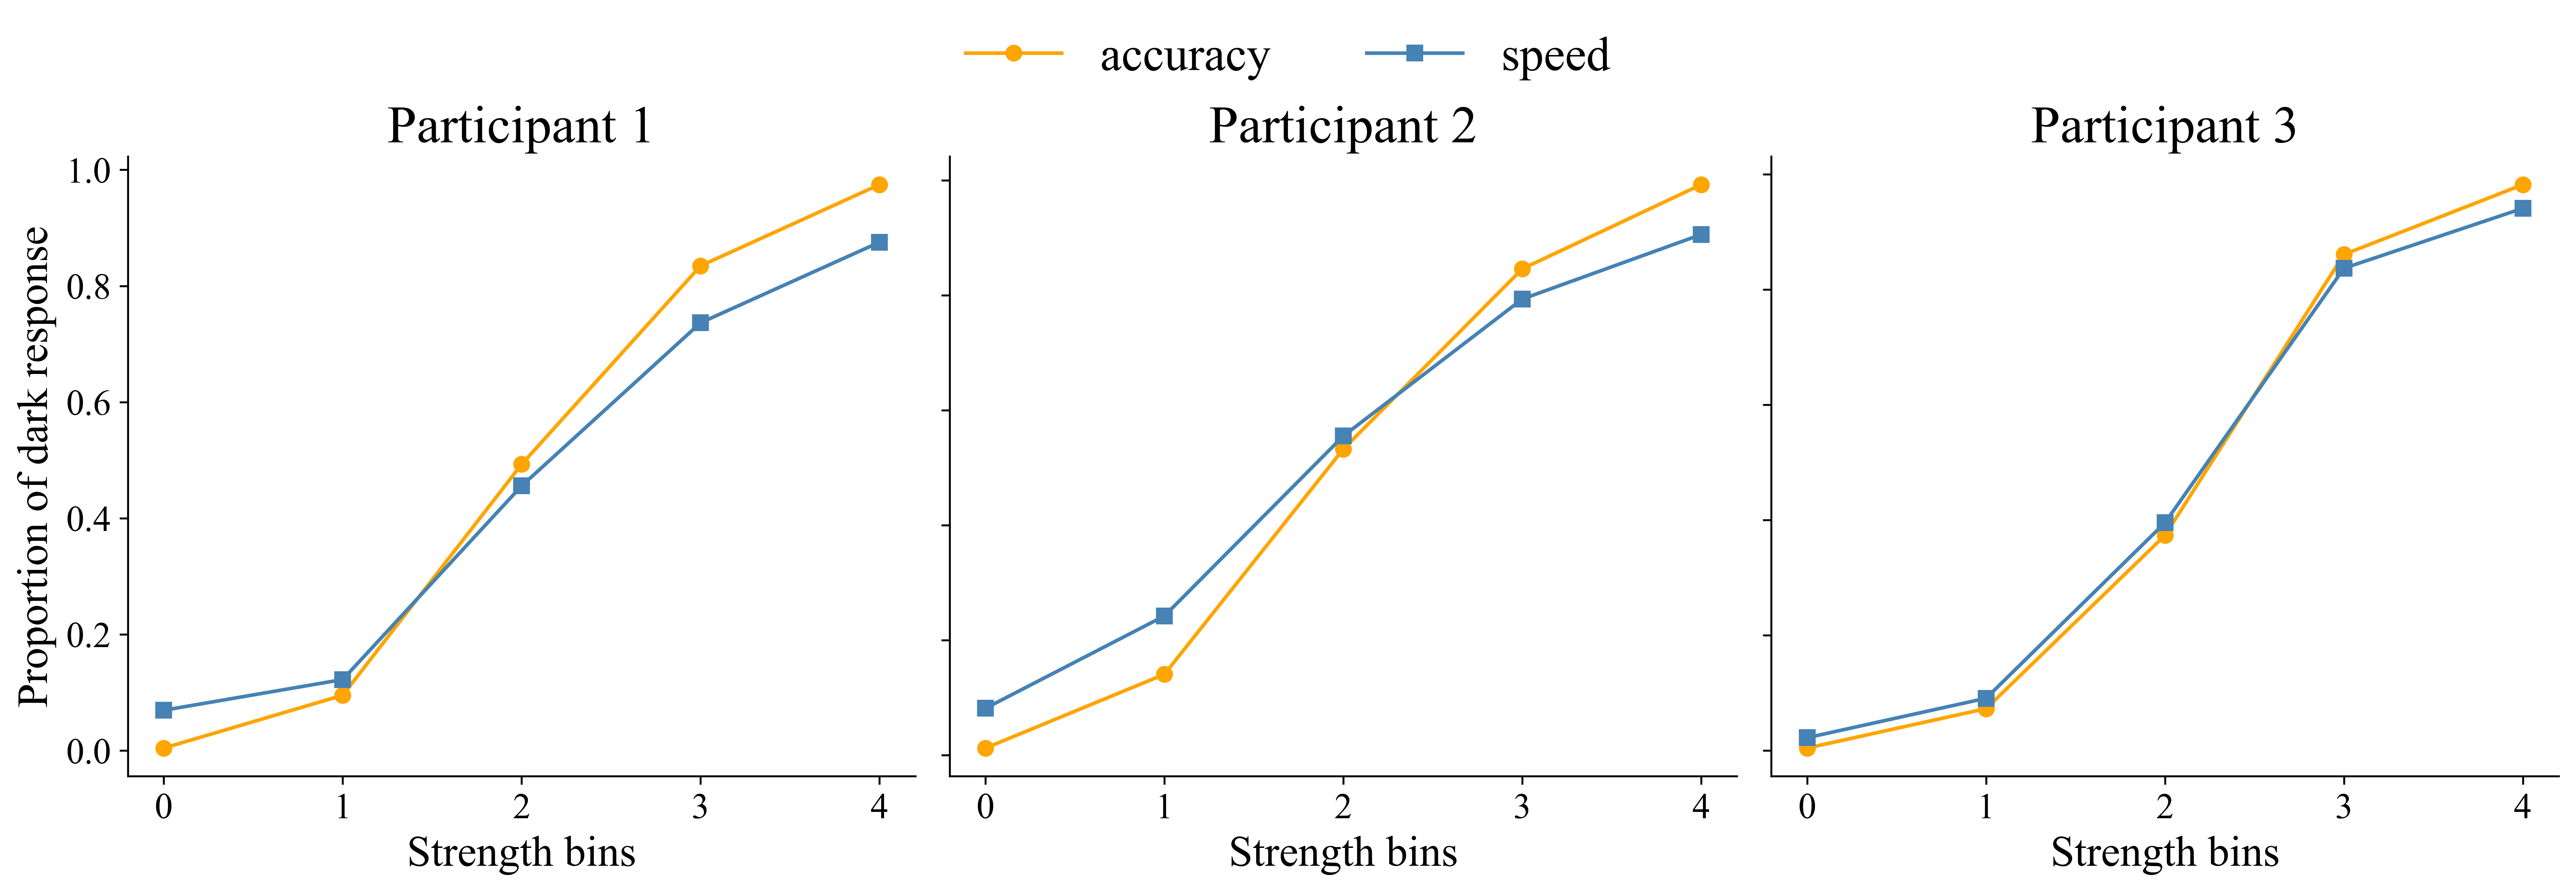

In [41]:
mean_response = rr98.groupby(['strength_bin','id','instruction'])['y'].mean().reset_index()
pivot_response = mean_response.pivot(index='strength_bin', columns=['id','instruction'], values='y')
import matplotlib.ticker as mticker

# Define a function for plotting a participant's data
def plot_participant(ax, participant_id, pivot_response, title, show_ylabel=False):
    ax.plot(pivot_response[participant_id]['accuracy'], label='accuracy', color='orange', marker='o', linestyle='-')
    ax.plot(pivot_response[participant_id]['speed'], label='speed', color='steelblue', marker='s', linestyle='-')
    ax.set_title(title, size=22)
    ax.set_xlabel('Strength bins', size=18)
    if show_ylabel:
        ax.set_ylabel('Proportion of dark response', size=18)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if not show_ylabel:
        ax.set_yticklabels([], size=12)
    ax.tick_params(axis='x', labelsize=15)  # Adjust font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.set_dpi(600)
plt.rcParams['font.family'] = 'Times New Roman'

# Participant data
participants = ['jf', 'kr', 'nh']
titles = ['Participant 1', 'Participant 2', 'Participant 3']

# Create subplots
for i, (participant, title) in enumerate(zip(participants, titles)):
    plot_participant(axes[i], participant, pivot_response, title, show_ylabel=(i == 0))

# Add a single legend for all subplots
fig.legend(['accuracy', 'speed'], loc='upper center', ncol=2, fontsize=20, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.savefig(root_dir/"plots/descriptive_stats.pdf", format="pdf", bbox_inches="tight")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


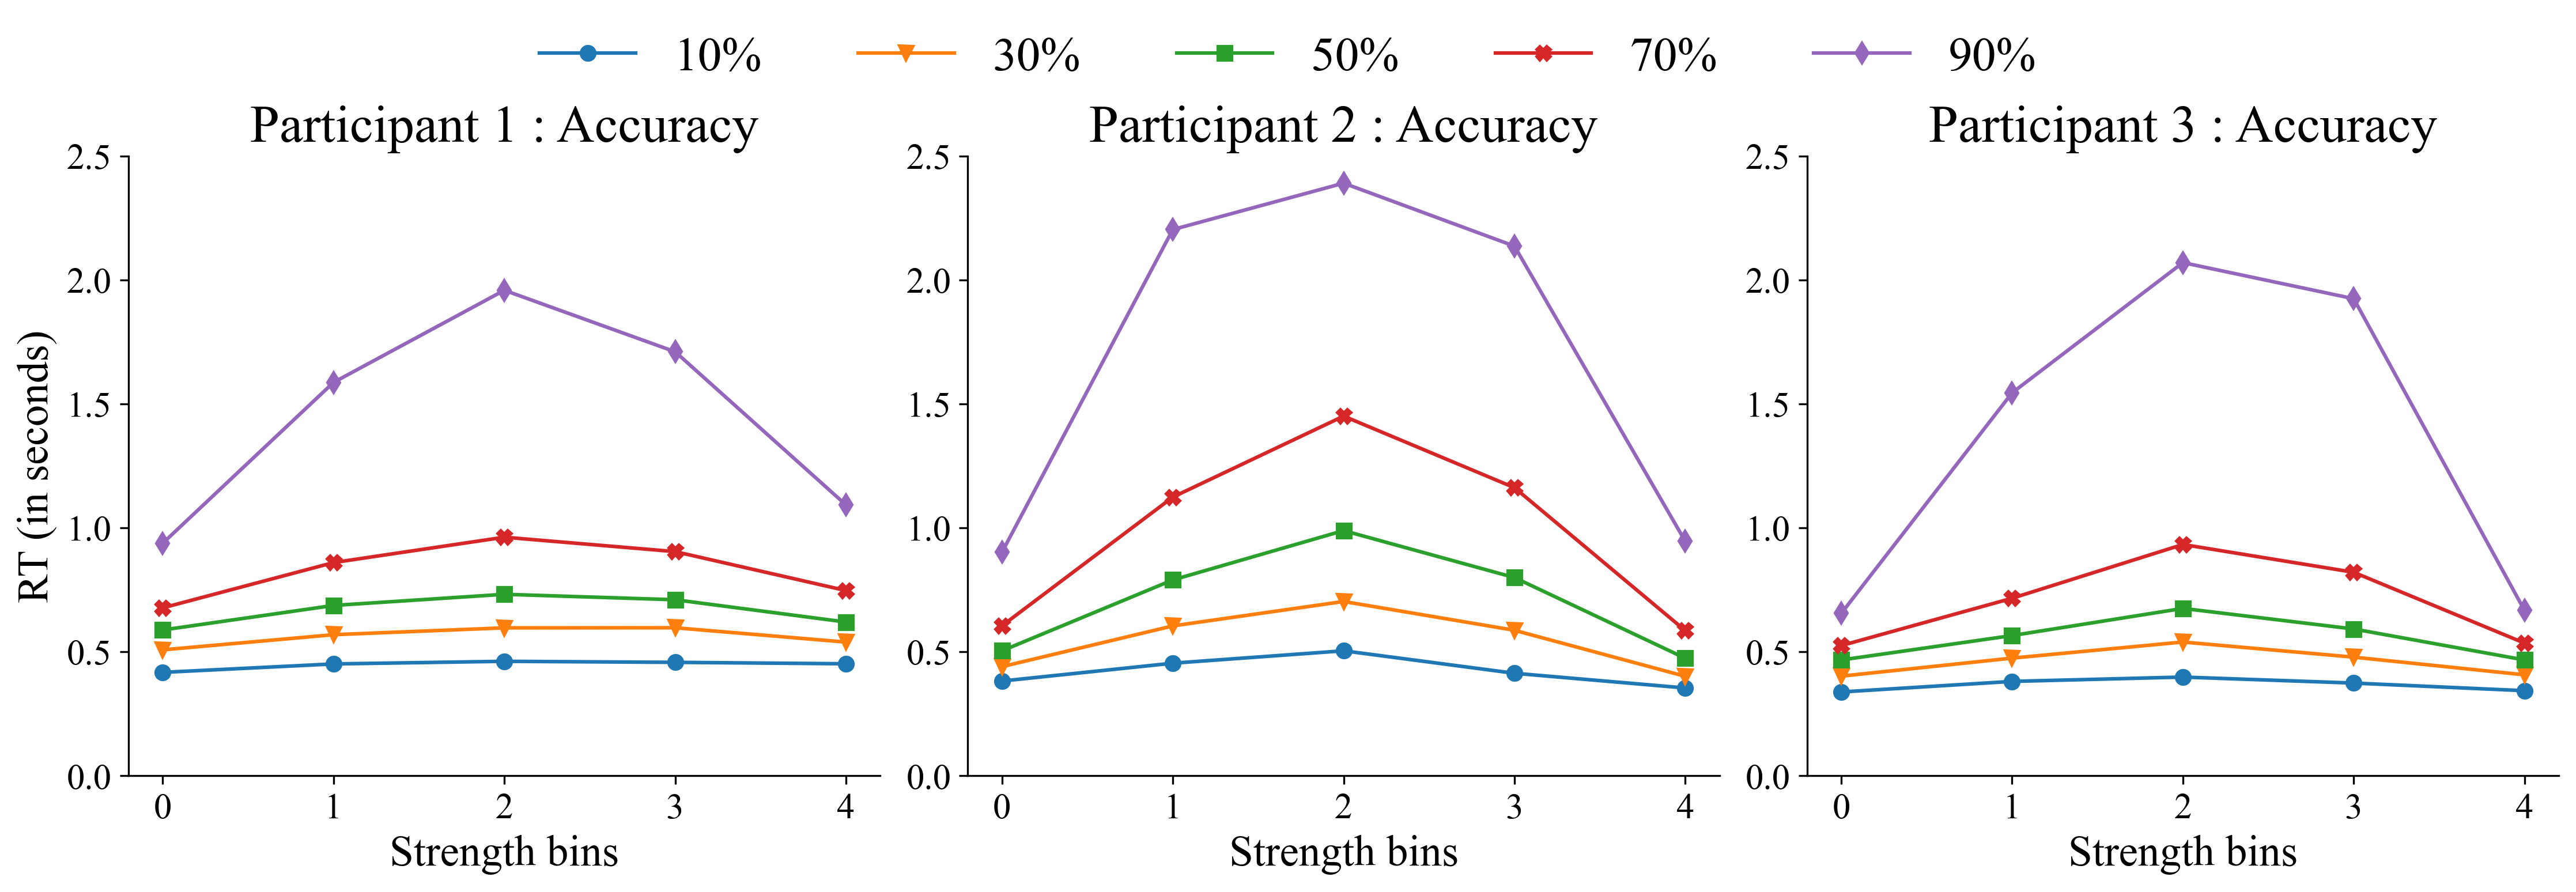

In [42]:
# Calculate quantiles
quantiles = rr98.groupby(['instruction', 'strength_bin', 'id'])['rt'].quantile([0.1, 0.3, 0.5, 0.7, 0.9]).unstack()

# Define a function to plot quantiles for a participant
def plot_quantiles(ax, quantiles, participant_id, title, show_ylabel=False):
    markers = ['o', 'v', 's', 'X', 'd']
    quantile_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    for q, marker in zip(quantile_levels, markers):
        ax.plot(quantiles.loc['accuracy', :, participant_id].loc[:, q], marker=marker)
    
    ax.set_title(title, size=22)
    ax.set_xlabel("Strength bins", size=18)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    if show_ylabel:
        ax.set_ylabel("RT (in seconds)", size=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 2.5)
    ax.tick_params(axis='x', labelsize=15)  # Adjust font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.set_dpi(300)
plt.rcParams['font.family'] = 'Times New Roman'

# Participant data
participants = ['jf', 'kr', 'nh']
titles = ["Participant 1 : Accuracy", "Participant 2 : Accuracy", "Participant 3 : Accuracy"]

# Create subplots
for i, (participant, title) in enumerate(zip(participants, titles)):
    plot_quantiles(axes[i], quantiles, participant, title, show_ylabel=(i == 0))

# Add a single legend for all subplots
fig.legend(['10%', '30%', '50%', '70%', '90%'], loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
plt.savefig(
    root_dir/"plots/quantile_plot_accuracy.pdf", 
    format="pdf", 
    bbox_inches="tight"
)


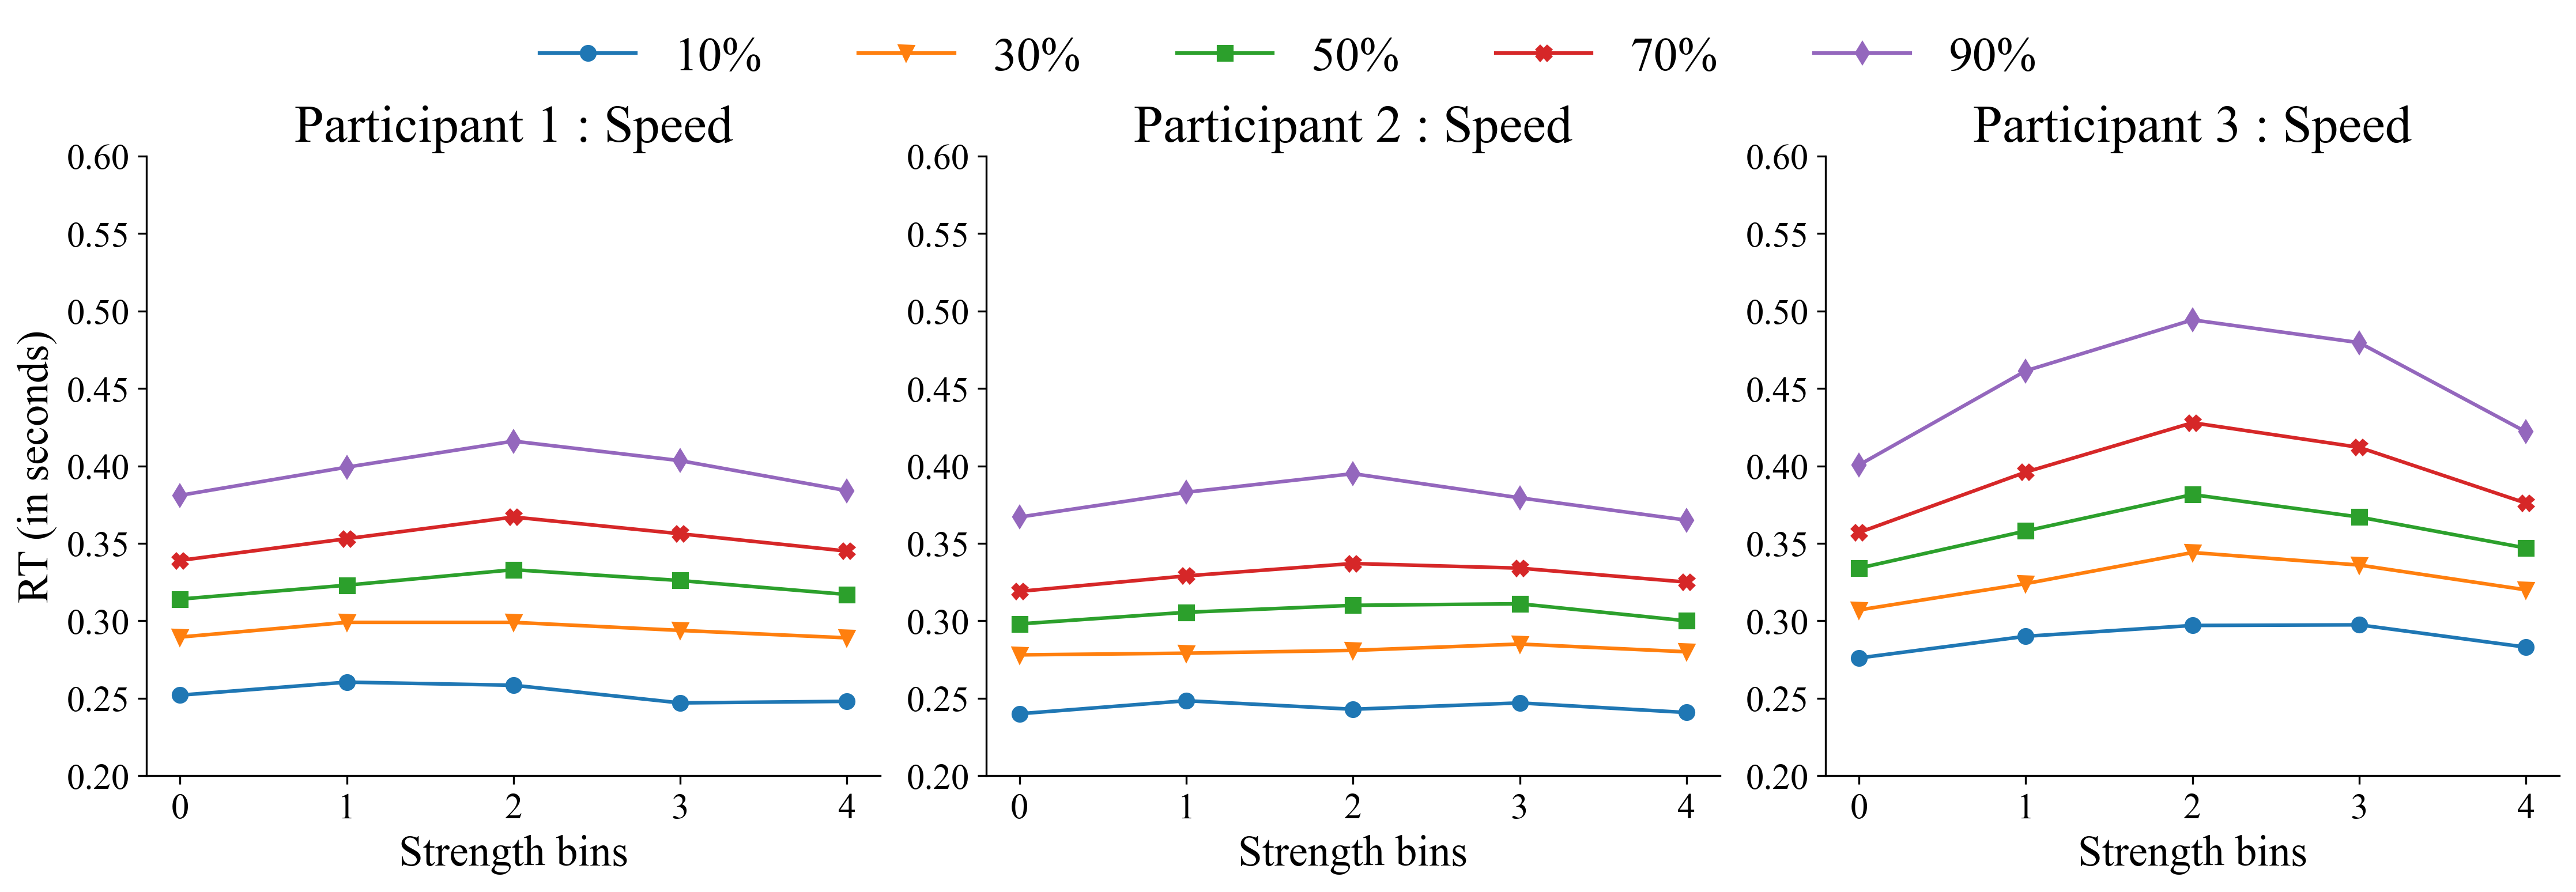

In [43]:
# Define a function to plot quantiles for a participant
def plot_quantiles(ax, quantiles, participant_id, title, show_ylabel=False):
    markers = ['o', 'v', 's', 'X', 'd']
    quantile_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
    
    for q, marker in zip(quantile_levels, markers):
        ax.plot(quantiles.loc['speed', :, participant_id].loc[:, q], marker=marker)
    
    ax.set_title(title, size=22)
    ax.set_xlabel("Strength bins", size=18)
    ax.xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
    if show_ylabel:
        ax.set_ylabel("RT (in seconds)", size=18)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0.2, 0.6)
    ax.tick_params(axis='x', labelsize=15)  # Adjust font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)
    
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.set_dpi(300)
plt.rcParams['font.family'] = 'Times New Roman'

# Participant data
participants = ['jf', 'kr', 'nh']
titles = ["Participant 1 : Speed", "Participant 2 : Speed", "Participant 3 : Speed"]

# Create subplots
for i, (participant, title) in enumerate(zip(participants, titles)):
    plot_quantiles(axes[i], quantiles, participant, title, show_ylabel=(i == 0))

# Add a single legend for all subplots
fig.legend(['10%', '30%', '50%', '70%', '90%'], loc='upper center', ncol=5, fontsize=20, bbox_to_anchor=(0.5, 1.05), frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
plt.savefig(
    root_dir/"plots/quantile_plot_speed.pdf", 
    format="pdf", 
    bbox_inches="tight"
)


In [44]:
rr98.loc[:, 'rt'] = np.log(rr98['rt'])
rr98_cleaned.loc[:, 'rt'] = np.log(rr98_cleaned['rt'])
def rr98_sub(rr98, sub, condition):
    filtered_data = rr98[(rr98.iloc[:, 0] == sub) & (rr98.iloc[:, 1] == condition)]
    filtered_data = filtered_data.drop(['id', 'instruction', 'response'], axis=1)
    filtered_data = filtered_data[['rt', 'y', 'y_dummy', 'strength_bin']].to_numpy()
    return {
        'summary_conditions': filtered_data.reshape(1, filtered_data.shape[0], filtered_data.shape[1]),
        'direct_conditions': np.sqrt(filtered_data.shape[0]).reshape(1, 1)
    }

# Define subjects, conditions, and datasets
subjects = ['jf', 'kr', 'nh']
conditions = ['speed', 'accuracy']
datasets = {'raw': rr98, 'cleaned': rr98_cleaned}

# Generate dictionaries for each combination of subject, condition, and dataset
def generate_sub_dicts(datasets, subjects, conditions):
    sub_dicts = {}
    for dataset_name, dataset in datasets.items():
        for sub in subjects:
            for cond in conditions:
                key = f"{sub}_{cond}_{dataset_name}"
                sub_dicts[key] = rr98_sub(dataset, sub, cond)
    return sub_dicts

# Generate all sub dictionaries
sub_dicts = generate_sub_dicts(datasets, subjects, conditions)

# Function to calculate results
def calculate_results(sub_dicts, amortizer, n_samples, mode):
    results = {}
    for key, sub_dict in sub_dicts.items():
        result_key = key.replace('_dict', f'_result_{mode}')
        results[result_key] = np.vstack((np.mean(amortizer.sample(sub_dict, n_samples=n_samples), axis=0), np.std(amortizer.sample(sub_dict, n_samples=n_samples), axis=0)))
    return results


In [45]:
results_standard = calculate_results(sub_dicts, amortizer_real_data_problem_standard, n_samples=1000, mode='standard')
results_robust = calculate_results(sub_dicts, amortizer_real_data_problem_robust, n_samples=1000, mode='robust')


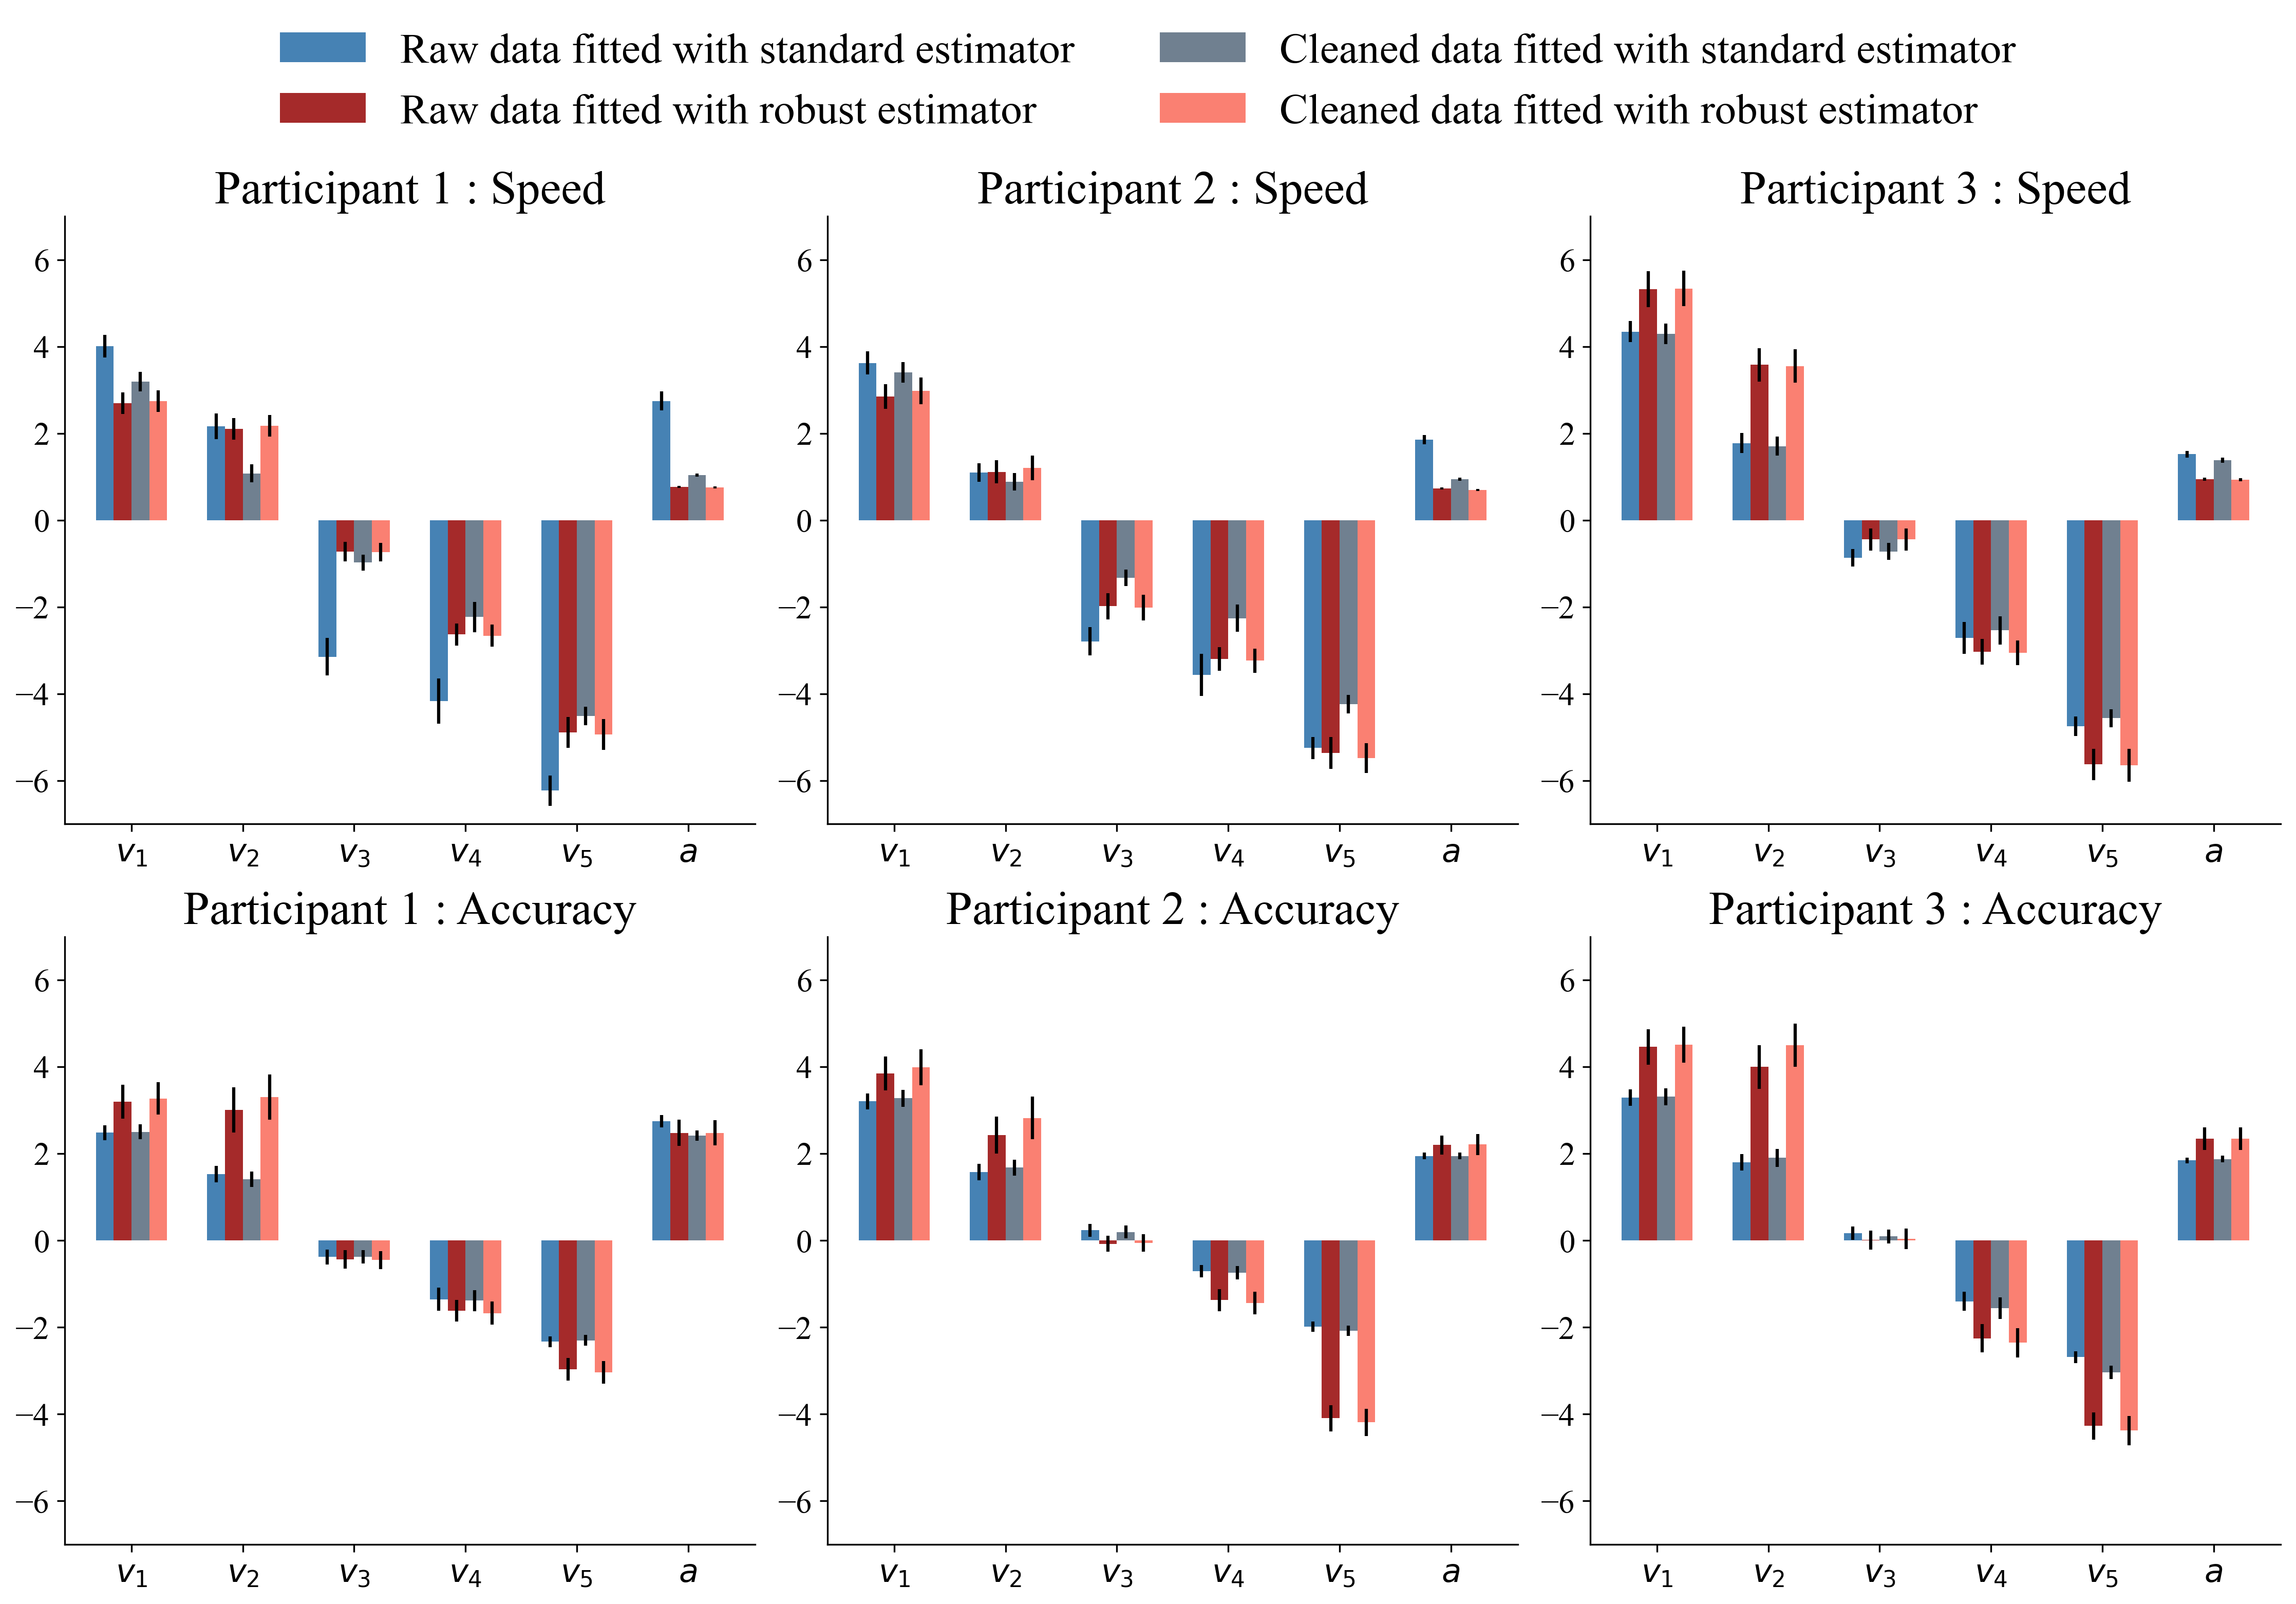

In [49]:
# Function to plot a single subplot
def plot_bar_subplot(ax, data, errors, tick_positions, offsets, bar_width, custom_labels, title):
    colors = ['steelblue', 'brown', 'slategray', 'salmon']
    labels = [
        'Raw data fitted in standard estimator',
        'Raw data fitted in robust estimator',
        'Cleaned data fitted in standard estimator',
        'Cleaned data fitted in robust estimator'
    ]
    
    for i, (offset, color) in enumerate(zip(offsets, colors)):
        ax.bar(tick_positions + offset * bar_width, data[i], yerr=errors[i], color=color, label=labels[i])
    
    ax.set_title(title, fontsize=22)
    ax.set_ylim(-7, 7)
    ax.set_xticks(tick_positions)  # Set custom tick positions
    ax.set_xticklabels(custom_labels, fontsize=15)  # Set custom labels
    ax.spines['top'].set_visible(False)  # Remove upper border
    ax.spines['right'].set_visible(False)  # Remove right border
    ax.tick_params(axis='x', labelsize=15)  # Adjust font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)
    
# Custom labels for the x-axis (five-letter strings)
custom_labels = [r'$v_1$', r'$v_2$', r'$v_3$', r'$v_4$', r'$v_5$', r'$a$']
tick_positions = np.linspace(0, 25, len(custom_labels))
bar_width = 0.8
offsets = [-1.5, -0.5, 0.5, 1.5]

# Data for participants and conditions
participants = ['Participant 1', 'Participant 2', 'Participant 3']
conditions = ['Speed', 'Accuracy']
data_dict = {
    'Speed': [
        [results_standard['jf_speed_raw'][0,0:6], results_robust['jf_speed_raw'][0,0:6], results_standard['jf_speed_cleaned'][0,0:6], results_robust['jf_speed_cleaned'][0,0:6]],
        [results_standard['kr_speed_raw'][0,0:6], results_robust['kr_speed_raw'][0,0:6], results_standard['kr_speed_cleaned'][0,0:6],results_robust['kr_speed_cleaned'][0,0:6]],
        [results_standard['nh_speed_raw'][0,0:6], results_robust['nh_speed_raw'][0,0:6], results_standard['nh_speed_cleaned'][0,0:6], results_robust['nh_speed_cleaned'][0,0:6]],
    ],
    'Accuracy': [
        [results_standard['jf_accuracy_raw'][0,0:6], results_robust['jf_accuracy_raw'][0,0:6], results_standard['jf_accuracy_cleaned'][0,0:6], results_robust['jf_accuracy_cleaned'][0,0:6]],
        [results_standard['kr_accuracy_raw'][0,0:6], results_robust['kr_accuracy_raw'][0,0:6], results_standard['kr_accuracy_cleaned'][0,0:6],  results_robust['kr_accuracy_cleaned'][0,0:6]],
        [results_standard['nh_accuracy_raw'][0,0:6], results_robust['nh_accuracy_raw'][0,0:6], results_standard['nh_accuracy_cleaned'][0,0:6], results_robust['nh_accuracy_cleaned'][0,0:6]],
    ]
}

error_dict = {
    'Speed': [
        [results_standard['jf_speed_raw'][1,0:6], results_robust['jf_speed_raw'][1,0:6], results_standard['jf_speed_cleaned'][1,0:6], results_robust['jf_speed_cleaned'][1,0:6]],
        [results_standard['kr_speed_raw'][1,0:6], results_robust['kr_speed_raw'][1,0:6], results_standard['kr_speed_cleaned'][1,0:6],results_robust['kr_speed_cleaned'][1,0:6]],
        [results_standard['nh_speed_raw'][1,0:6], results_robust['nh_speed_raw'][1,0:6], results_standard['nh_speed_cleaned'][1,0:6], results_robust['nh_speed_cleaned'][1,0:6]],
    ],
    'Accuracy': [
        [results_standard['jf_accuracy_raw'][1,0:6], results_robust['jf_accuracy_raw'][1,0:6], results_standard['jf_accuracy_cleaned'][1,0:6], results_robust['jf_accuracy_cleaned'][1,0:6]],
        [results_standard['kr_accuracy_raw'][1,0:6], results_robust['kr_accuracy_raw'][1,0:6], results_standard['kr_accuracy_cleaned'][1,0:6],  results_robust['kr_accuracy_cleaned'][1,0:6]],
        [results_standard['nh_accuracy_raw'][1,0:6], results_robust['nh_accuracy_raw'][1,0:6], results_standard['nh_accuracy_cleaned'][1,0:6], results_robust['nh_accuracy_cleaned'][1,0:6]],
    ]
}

# Create the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.set_dpi(300)

# Generate subplots dynamically
for row_idx, condition in enumerate(conditions):
    for col_idx, participant in enumerate(participants):
        plot_bar_subplot(
            axes[row_idx, col_idx],
            data_dict[condition][col_idx],
            error_dict[condition][col_idx],
            tick_positions,
            offsets,
            bar_width,
            custom_labels,
            title=f'{participant} : {condition}'
        )

# Add a single legend for all subplots
fig.legend(
    ['Raw data fitted with standard estimator', 'Raw data fitted with robust estimator', 'Cleaned data fitted with standard estimator', 'Cleaned data fitted with robust estimator'],
    loc='upper center',
    ncol=2,
    fontsize=20,
    bbox_to_anchor=(0.5, 1.05),
    frameon=False
)

plt.savefig(
    root_dir/"plots/real_data_inference_va.pdf", 
    format="pdf", 
    bbox_inches="tight"
)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


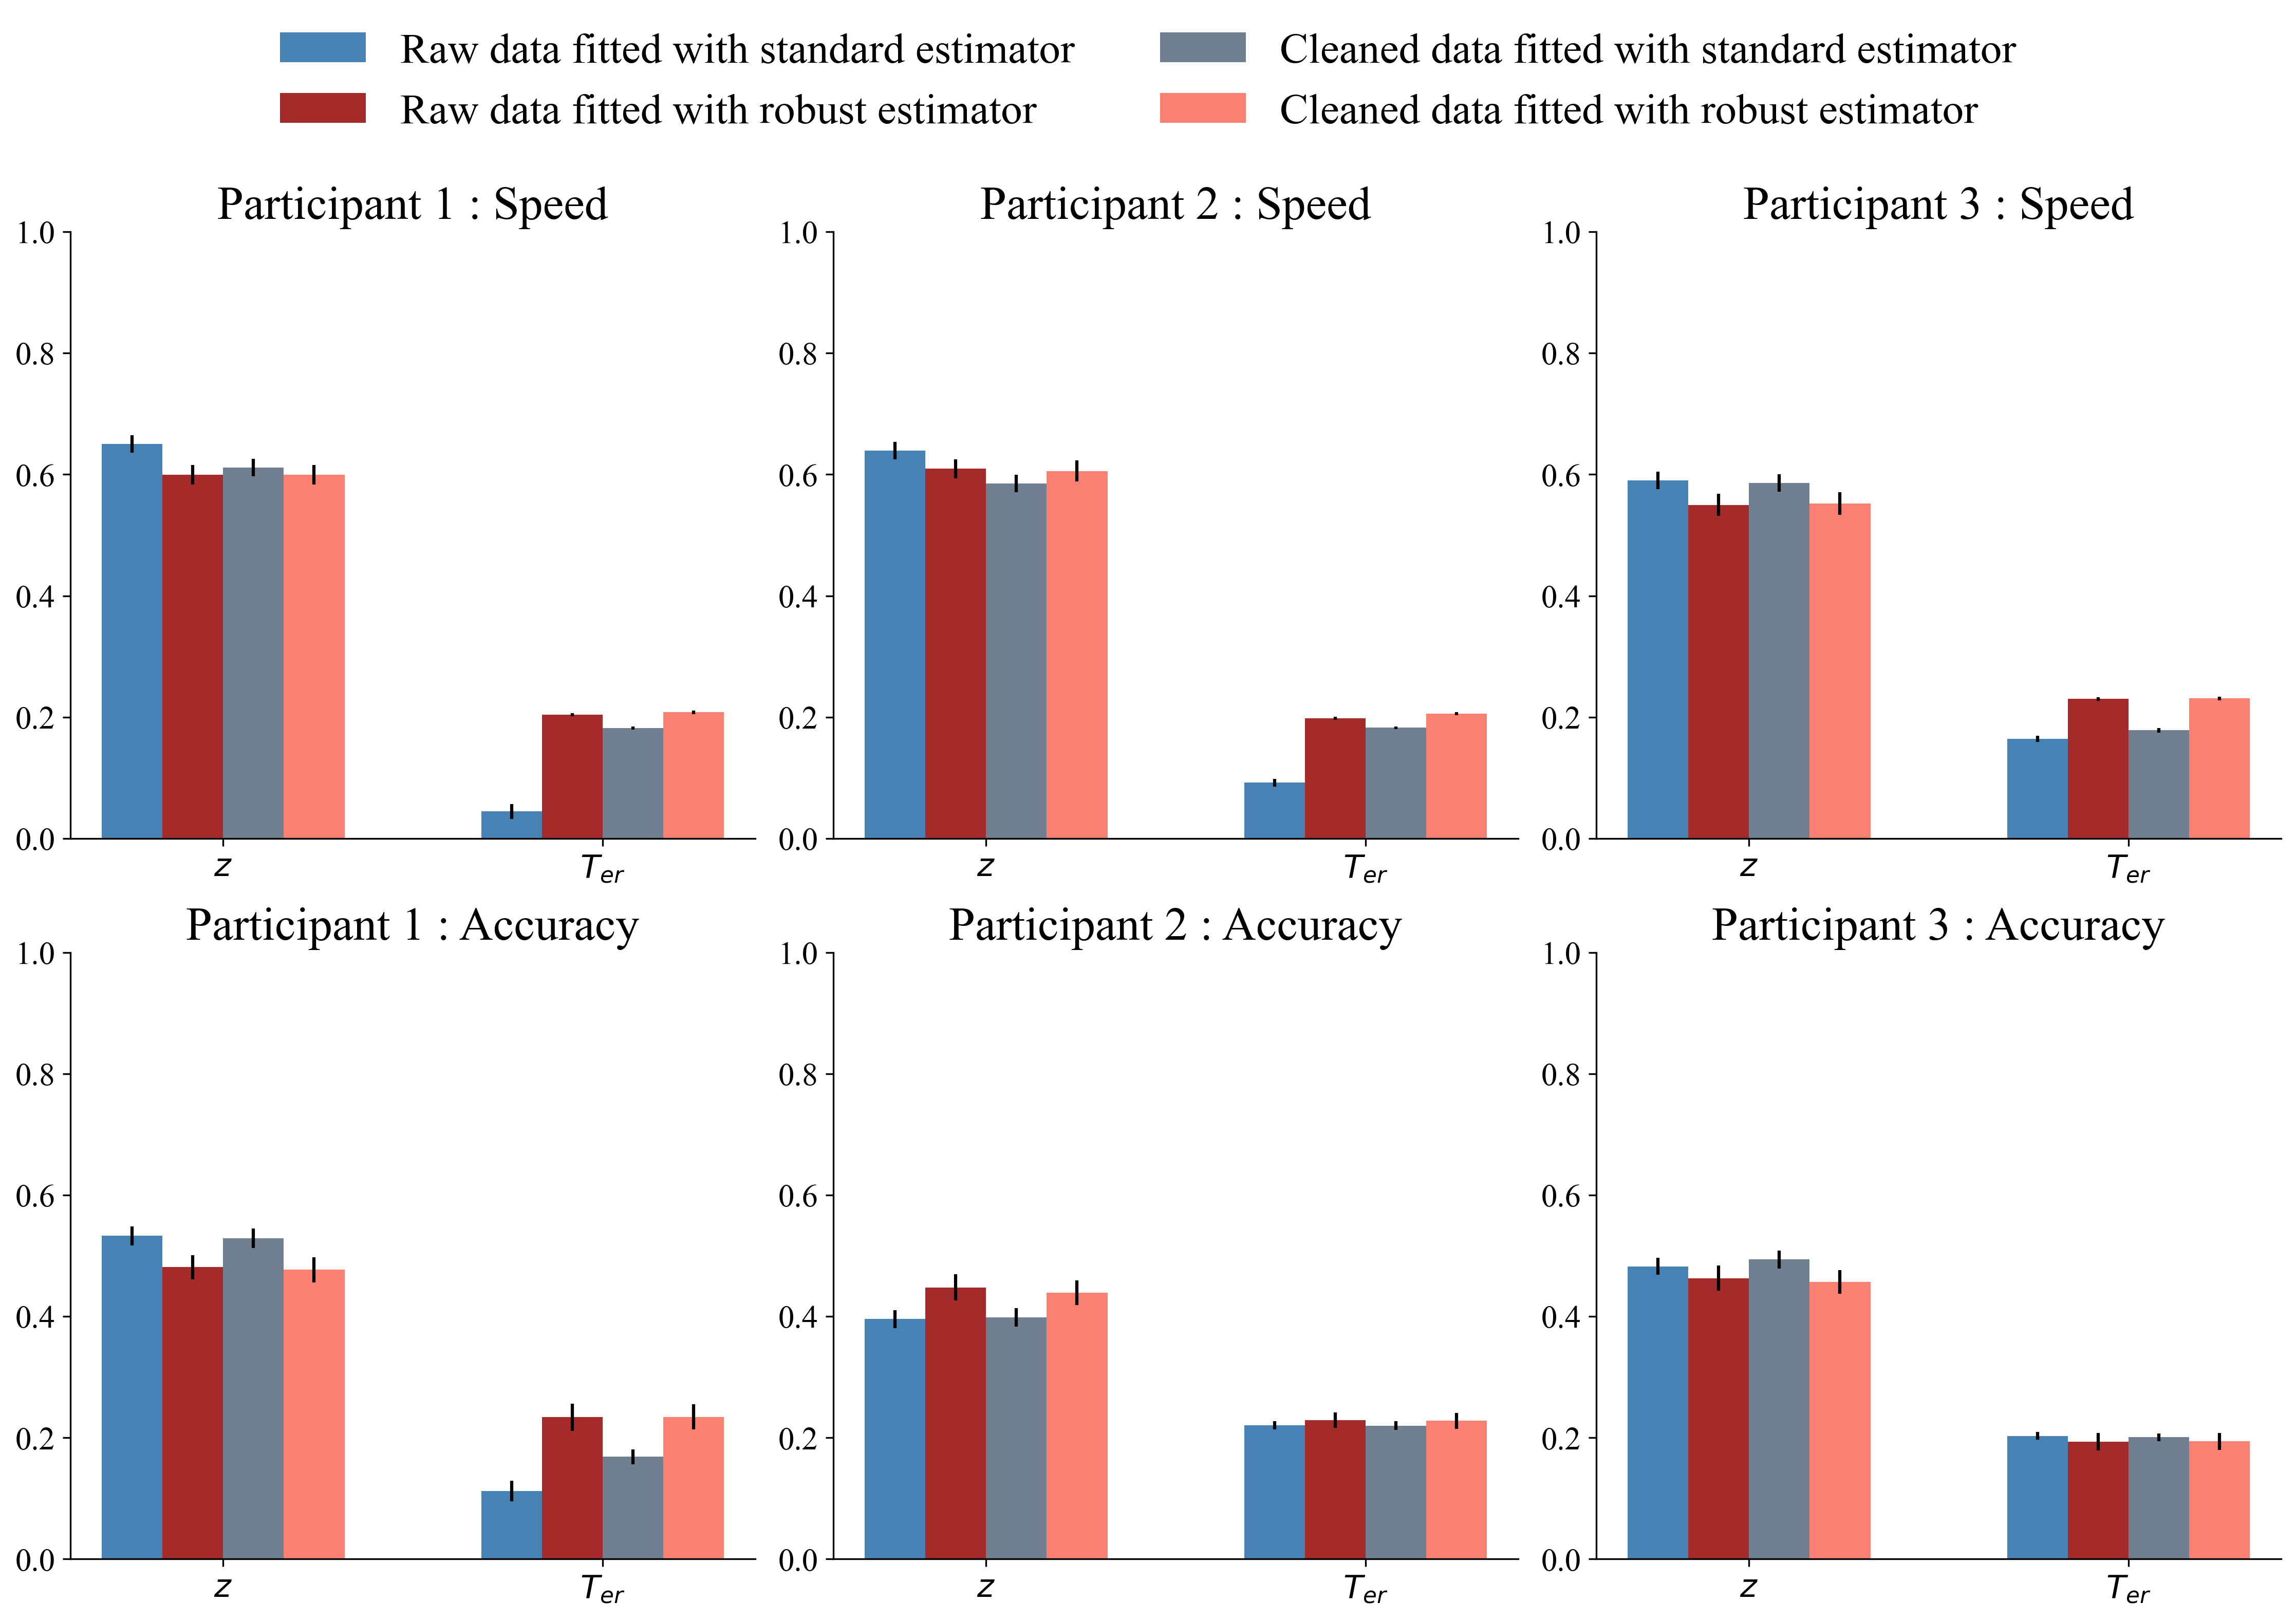

In [48]:
# Function to plot a single subplot
def plot_bar_subplot(ax, data, errors, tick_positions, offsets, bar_width, custom_labels, title):
    colors = ['steelblue', 'brown', 'slategray', 'salmon']
    labels = [
        'Raw data fitted in standard estimator',
        'Raw data fitted in robust estimator',
        'Cleaned data fitted in standard estimator',
        'Cleaned data fitted in robust estimator'
    ]
    
    for i, (offset, color) in enumerate(zip(offsets, colors)):
        ax.bar(tick_positions + offset * bar_width, data[i], yerr = errors[i], color=color, label=labels[i])
    
    ax.set_title(title, fontsize=22)
    ax.set_ylim(0, 1)
    ax.set_xticks(tick_positions)  # Set custom tick positions
    ax.set_xticklabels(custom_labels, fontsize=15)  # Set custom labels
    ax.spines['top'].set_visible(False)  # Remove upper border
    ax.spines['right'].set_visible(False)  # Remove right border
    ax.tick_params(axis='x', labelsize=15)  # Adjust font size for x-axis tick labels
    ax.tick_params(axis='y', labelsize=15)
    
# Custom labels for the x-axis (five-letter strings)
custom_labels = [ r'$z$', r'$T_{er}$']
tick_positions = np.linspace(0, 5, len(custom_labels))

bar_width = 0.8
offsets = [-1.5, -0.5, 0.5, 1.5]

# Data for participants and conditions
participants = ['Participant 1', 'Participant 2', 'Participant 3']
conditions = ['Speed', 'Accuracy']
data_dict = {
    'Speed': [
        [results_standard['jf_speed_raw'][0, 6:8], results_robust['jf_speed_raw'][0,6:8], results_standard['jf_speed_cleaned'][0,6:8], results_robust['jf_speed_cleaned'][0,6:8]],
        [results_standard['kr_speed_raw'][0,6:8], results_robust['kr_speed_raw'][0,6:8], results_standard['kr_speed_cleaned'][0,6:8],results_robust['kr_speed_cleaned'][0,6:8]],
        [results_standard['nh_speed_raw'][0,6:8], results_robust['nh_speed_raw'][0,6:8], results_standard['nh_speed_cleaned'][0,6:8], results_robust['nh_speed_cleaned'][0,6:8]],
    ],
    'Accuracy': [
        [results_standard['jf_accuracy_raw'][0,6:8], results_robust['jf_accuracy_raw'][0,6:8], results_standard['jf_accuracy_cleaned'][0,6:8], results_robust['jf_accuracy_cleaned'][0,6:8]],
        [results_standard['kr_accuracy_raw'][0,6:8], results_robust['kr_accuracy_raw'][0,6:8], results_standard['kr_accuracy_cleaned'][0,6:8],  results_robust['kr_accuracy_cleaned'][0,6:8]],
        [results_standard['nh_accuracy_raw'][0,6:8], results_robust['nh_accuracy_raw'][0,6:8], results_standard['nh_accuracy_cleaned'][0,6:8], results_robust['nh_accuracy_cleaned'][0,6:8]],
    ]
}

error_dict = {
    'Speed': [
        [results_standard['jf_speed_raw'][1,6:8], results_robust['jf_speed_raw'][1,6:8], results_standard['jf_speed_cleaned'][1,6:8], results_robust['jf_speed_cleaned'][1,6:8]],
        [results_standard['kr_speed_raw'][1,6:8], results_robust['kr_speed_raw'][1,6:8], results_standard['kr_speed_cleaned'][1,6:8],results_robust['kr_speed_cleaned'][1,6:8]],
        [results_standard['nh_speed_raw'][1,6:8], results_robust['nh_speed_raw'][1,6:8], results_standard['nh_speed_cleaned'][1,6:8], results_robust['nh_speed_cleaned'][1,6:8]],
    ],
    'Accuracy': [
        [results_standard['jf_accuracy_raw'][1,6:8], results_robust['jf_accuracy_raw'][1,6:8], results_standard['jf_accuracy_cleaned'][1,6:8], results_robust['jf_accuracy_cleaned'][1,6:8]],
        [results_standard['kr_accuracy_raw'][1,6:8], results_robust['kr_accuracy_raw'][1,6:8], results_standard['kr_accuracy_cleaned'][1,6:8],  results_robust['kr_accuracy_cleaned'][1,6:8]],
        [results_standard['nh_accuracy_raw'][1,6:8], results_robust['nh_accuracy_raw'][1,6:8], results_standard['nh_accuracy_cleaned'][1,6:8], results_robust['nh_accuracy_cleaned'][1,6:8]],
    ]
}

# Create the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.set_dpi(300)

# Generate subplots dynamically
for row_idx, condition in enumerate(conditions):
    for col_idx, participant in enumerate(participants):
        plot_bar_subplot(
            axes[row_idx, col_idx],
            data_dict[condition][col_idx],
            error_dict[condition][col_idx],
            tick_positions,
            offsets,
            bar_width,
            custom_labels,
            title=f'{participant} : {condition}'
        )

# Add a single legend for all subplots
fig.legend(
    ['Raw data fitted with standard estimator', 'Raw data fitted with robust estimator', 'Cleaned data fitted with standard estimator', 'Cleaned data fitted with robust estimator'],
    loc='upper center',
    ncol=2,
    fontsize=20,
    bbox_to_anchor=(0.5, 1.06),
    frameon=False
)

plt.savefig(
    root_dir/"plots/real_data_inference_zt.pdf", 
    format="pdf", 
    bbox_inches="tight"
)

# Adjust layout and show the plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
